In [2]:
# import libraries
import torchvision
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

In [3]:
# check device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps" if torch.backends.mps.is_available() else device)

print(device)

mps


In [4]:
# prepare dataset
trainDataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

testDataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# Confirm they are in grayscale (they should already be).
# should be [1, 28, 28], 1 channel, 28x28 pixels (grayscale)
print(trainDataset[0][0].shape)
print(testDataset[0][0].shape)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


In [5]:
def siftFeatureDetector(image):
    sift = cv2.SIFT_create()
    image = (image * 255).astype(np.uint8)
    _, descriptors = sift.detectAndCompute(image, None)

    if descriptors is None:
        return np.array([])
    return descriptors

In [6]:
def extraDescriptorsAndLabels(dataSet, batch_size=128):
    data_loader = torch.utils.data.DataLoader(
        dataSet, batch_size=batch_size, shuffle=False)

    all_descriptors = []
    all_labels = []

    # use tqdm to show progress bar
    for images, labels in tqdm(data_loader, desc="Processing Batches", unit="batch"):
        images = images.numpy()
        labels = labels.numpy()
        
        for image, label in zip(images, labels):
            image = image.squeeze(0)
            
            descriptors = siftFeatureDetector(image)
            if len(descriptors) > 0:
                all_descriptors.append(descriptors)
                all_labels.append(label)
                
    # verify that the descriptors and the labels are being stored correctly
    if len(all_descriptors) == len(all_labels):
        all_descriptors = np.vstack(all_descriptors) 
        return all_descriptors, all_labels
    else:
        print("Error: descriptors and labels are not the same length")
        return None

In [7]:
class Task1_MLP(nn.Module):
    def __init__(self, input_dim=72, hidden_dim=128, output_dim=10):
        super(Task1_MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [8]:
# task 1
# 1. SIFT Feature Extraction
#  1.1 Apply the SIFT feature detector to each image
train_descriptors, train_labels = extraDescriptorsAndLabels(trainDataset)
test_descriptors, test_labels = extraDescriptorsAndLabels(testDataset)
train_descriptors = normalize(train_descriptors, axis=1)
test_descriptors = normalize(test_descriptors, axis=1)

Processing Batches: 100%|██████████| 79/79 [00:03<00:00, 24.41batch/s]


In [9]:
#  1.2 Obtain a suitable representation of the SIFT descriptors as we learned in the class
# use the K-means clustering algorithm to cluster the descriptors
# convert the descriptors to visual words
valid_descriptors = [d for d in train_descriptors if d is not None and len(d) > 0]        
features = np.vstack(valid_descriptors)
print(f"trainnig feature shape: {features.shape}")  # (num_descriptors, 128)

trainnig feature shape: (241390, 128)


In [10]:
# this step is to determine the number of clusters, but it takes too long to run
# and cluster number is determined so we can skip this step
if 1:
    reduced_amount = 50000
    reduced_features = features[:reduced_amount]
    silhouette_scores = []
    k_values = range(40, 80)

    for k in tqdm(k_values, desc="calculate Inertia"):
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(reduced_features)
        score = silhouette_score(reduced_features, labels)
        silhouette_scores.append(score)

    # draw Silhouette Score curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o', color='orange')
    plt.xlabel('k_values')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. k_values')
    plt.grid(True)
    plt.show()
    # when cluster number is 78 the silhouette score is the highest

calculate Inertia:  40%|████      | 16/40 [05:52<08:49, 22.04s/it]

In [ ]:
k_clusters = 78
k_means = KMeans(n_clusters=k_clusters, random_state=0)
reduced_features = np.array(features[:500000]).reshape(-1, 1)
del features
k_means.fit(reduced_features)

print(reduced_features[0])
test = k_means.predict(reduced_features[0].reshape(-1, 1))
print(test)

KeyboardInterrupt: 

In [15]:
print(reduced_features[0])
test = k_means.predict([reduced_features[0], reduced_features[1]])
print(test)

[0.0254447  0.         0.         0.         0.         0.
 0.         0.00782914 0.31903738 0.01370099 0.         0.
 0.         0.         0.         0.08416323 0.31903738 0.01174371
 0.         0.01370099 0.01370099 0.00782914 0.00391457 0.07046224
 0.00195728 0.00195728 0.00978642 0.05480397 0.04501754 0.00978642
 0.00195728 0.00195728 0.05871854 0.00195728 0.         0.
 0.         0.         0.         0.00782914 0.31903738 0.05676125
 0.         0.         0.         0.         0.         0.14679635
 0.31903738 0.04893211 0.01761556 0.06654768 0.0254447  0.
 0.         0.07241952 0.         0.         0.00782914 0.30729365
 0.08220595 0.         0.         0.         0.03131655 0.00391457
 0.         0.         0.         0.         0.         0.
 0.31903738 0.23487414 0.00782914 0.         0.         0.
 0.         0.00782914 0.11547979 0.20942944 0.23683143 0.16636918
 0.00391457 0.         0.         0.00195728 0.         0.
 0.12330893 0.31903738 0.02153013 0.         0.    

In [25]:
def descriptors_to_vector(descriptors, kmeans_model, k_clusters=72):
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(k_clusters)  # 如果描述符为空，返回全零向量

    features = []
    for d in descriptors:
        if d is None or len(d) == 0:
            continue
        for descriptor in d:
            features.append(d)

    # # 保证 descriptors 是二维数组
    vectors = np.zeros(k_clusters)
    print(type(descriptors))
    print(descriptors.shape)
    
    for descriptor in descriptors[0]:
        print(descriptor)
    
    cluster_labels = kmeans_model.predict(descriptors)
    histogram, _ = np.histogram(cluster_labels, bins=np.arange(k_clusters + 1))
    histogram = histogram / np.linalg.norm(histogram) if np.linalg.norm(histogram) != 0 else histogram

    return histogram
    print('----------------------------------------')

<class 'numpy.ndarray'>
(5, 128)
13.0
0.0
0.0
0.0
0.0
0.0
0.0
4.0
163.0
7.0
0.0
0.0
0.0
0.0
0.0
43.0
163.0
6.0
0.0
7.0
7.0
4.0
2.0
36.0
1.0
1.0
5.0
28.0
23.0
5.0
1.0
1.0
30.0
1.0
0.0
0.0
0.0
0.0
0.0
4.0
163.0
29.0
0.0
0.0
0.0
0.0
0.0
75.0
163.0
25.0
9.0
34.0
13.0
0.0
0.0
37.0
0.0
0.0
4.0
157.0
42.0
0.0
0.0
0.0
16.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
163.0
120.0
4.0
0.0
0.0
0.0
0.0
4.0
59.0
107.0
121.0
85.0
2.0
0.0
0.0
1.0
0.0
0.0
63.0
163.0
11.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
5.0
17.0
20.0
0.0
0.0
0.0
0.0
0.0
0.0
13.0
55.0
0.0
0.0
0.0
0.0


ValueError: Buffer dtype mismatch, expected 'const float' but got 'double'

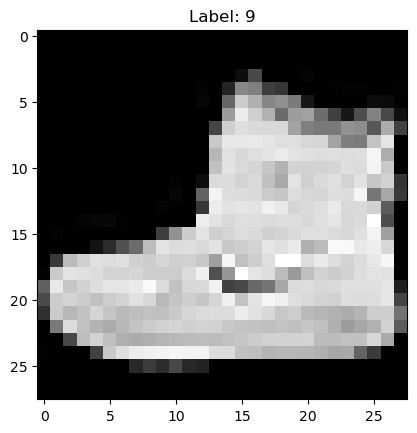

In [ ]:
# print example train data
image = trainDataset[0][0].numpy().squeeze(0)
label = trainDataset[0][1]
plt.title(f"Label: {label}")
plt.imshow(image, cmap='gray')

descriptors = siftFeatureDetector(image)
vector = descriptors_to_vector(descriptors, k_means, k_clusters)
# print(vector)

In [ ]:
#  1.3 Document how you constructed the final feature vector (feature dimensionality, etc.).
train_vectors = []
train_labels = []
for image, label in tqdm(trainDataset, desc="Processing Batches", unit="batch"):
    image = image.numpy().squeeze(0)
    descriptors = siftFeatureDetector(image)
    train_labels.append(label)
    for descriptor in descriptors:
        train_vectors.append(descriptors_to_vector(descriptor, k_means, k_clusters))
    
    train_vectors.append(descriptors_to_vector(descriptors, k_means, k_clusters))
    # train_vectors.append(descriptors_to_vector(item, k_means, k_clusters))

test_vectors = []
# for item in test_descriptors:
# test_vectors.append(descriptors_to_vector(item, k_means, k_clusters))

# 2. MLP Training
#  2.1 MLP architecture: Use up to two hidden layers. Define the number of neurons in each layer (layer size).
#  2.2 Hyperparameter Tuning: See the next section for the list of hyperparameters to experiment with.
#  2.3 Train on the training set, evaluate on both training and testing sets.
# 3. Accuracy Reporting
#  3.1 Report and compare the training vs. testing accuracy for each experiment.

In [ ]:

# descriptors may be of different lengths, so we need to pad them
# get the maximum length of the descriptors
maxLength = 0
maxIdx = 0
for (i, descriptor) in enumerate(train_descriptors):
    if type(descriptor) == type(None):
        continue
    if len(descriptor) > maxLength:
        maxLength = len(descriptor)
        maxIdx = i
# max_length = max([len(descriptor) for descriptor in train_descriptors])
print(f"Max length of descriptors: {maxLength}")

# print the descriptor at the max index
print(train_descriptors[maxIdx])

# create model
model = Task1_MLP()

In [ ]:
# convert 28*28 image to 784-dim vector
def imageToVector(image):
    return image.view(-1, 28 * 28)

# train the model
model = Task1_MLP().to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train the model
num_epochs = 50
batch_size = 600
train_loader = torch.utils.data.DataLoader(
    trainDataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(
        train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (images, labels) in loop:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(imageToVector(images))
        loss = criterion(outputs, labels)

        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) == loop.total:
            print(
                f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item()}')